In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp


In [2]:
from typing import List

import os

In [3]:
import numpy as np
import h5py
import json
import glob
import matplotlib.pyplot as plt
import matplotlib

from examples.make_plots_pipeline import PreloadedVloaders
from examples.budget_analysis_data import BudgetVloaders

%matplotlib inline

matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

matplotlib.rcParams['figure.dpi']= 150

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

viridis = plt.get_cmap("viridis")
plasma = plt.get_cmap("plasma")

In [4]:
%matplotlib inline

# Budget Size Estimation based on Ji (2021)

In [5]:
# Load all the emulator validation data from the folders, including ar1, nargp, dgmgp
# including all redshifts, all num lf and num hf

# NOTE: only use num_hf > 2 because num_hf = 2 the NARGP is not optimized
bdget_loader = BudgetVloaders()

 /Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:149: RuntimeWarning:overflow encountered in power
 /Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:133: RuntimeWarning:invalid value encountered in divide


In [6]:
# all shared parameters
res_l = 128
res_h = 512
box_l = 256
box_l_2 = 100
box_h = 256

# all parameters for looping
z       = [0, 0.2, 0.5, 1.0, 2.0, 3.0]
all_lfs = [12, 18, 24, 30, 36, 42, 48, 54, 60, ]
all_hfs = list(range(3, 19))

available_slices = [57, 58, 59, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
all_slices       = [
    sorted(available_slices[:i]) for i in all_hfs
]

# Average over the k bins first, then the std over the test points
# Shape: (number of HF points, number of LF points)
all_dgmgp_errors = np.full(
    (len(all_hfs), len(all_lfs)),
    fill_value = np.nan,
)
all_dgmgp_stds = np.full(
    (len(all_hfs), len(all_lfs)),
    fill_value = np.nan,
)
all_ar1_errors = np.full(
    (len(all_hfs), len(all_lfs)),
    fill_value = np.nan,
)
all_ar1_stds = np.full(
    (len(all_hfs), len(all_lfs)),
    fill_value = np.nan,
)
all_nargp_errors = np.full(
    (len(all_hfs), len(all_lfs)),
    fill_value = np.nan,
)
all_nargp_stds = np.full(
    (len(all_hfs), len(all_lfs)),
    fill_value = np.nan,
)

# Store the num of LF and HF points for later use
# Format: (num hf, num lf)
hf_lf_points = []

for i,(num_hf, slice) in enumerate(zip(all_hfs, all_slices)):
    for j,num_lf in enumerate(all_lfs):
        ### dGMGP ###
        # loading emulator at num_hf + num_lf
        emulator = getattr(bdget_loader,
            "dgmgp_L{}_L2box{}_H{}_z0_1_2_slice_{}".format(
                num_lf, box_l_2, num_hf, "_".join(map(str, slice))
            )
        )
        # Average                                        : tests and bins  : over redshifts
        all_dgmgp_errors[i, j] = emulator.relative_errors.mean(axis=(1, 2)).mean() 
        all_dgmgp_stds[i, j]   = emulator.relative_errors.mean(axis=(1, 2)).std()

        ### AR1 ###
        # loading emulator at num_hf + num_lf
        emulator = getattr(bdget_loader,
            "ar1_L{}_H{}_z0_1_2_slice_{}".format(
                    num_lf, num_hf, "_".join(map(str, slice))
            )
        )
        # Average                                        : tests and bins  : over redshifts
        all_ar1_errors[i, j] = emulator.relative_errors.mean(axis=(1, 2)).mean() 
        all_ar1_stds[i, j]   = emulator.relative_errors.mean(axis=(1, 2)).std()


        ### NARGP ###
        # loading emulator at num_hf + num_lf
        emulator = getattr(bdget_loader,
            "nargp_L{}_H{}_z0_1_2_slice_{}".format(
                    num_lf, num_hf, "_".join(map(str, slice))
            )
        )
        # Average                                        : tests and bins  : over redshifts
        all_nargp_errors[i, j] = emulator.relative_errors.mean(axis=(1, 2)).mean()
        all_nargp_stds[i, j]   = emulator.relative_errors.mean(axis=(1, 2)).std()

        hf_lf_points.append((num_hf, num_lf))


In [7]:
# Flatten the arrays and prepare to save into txt files
folder = "budget_size"
base_dir = "/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/"

os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

# input (hf, lf) pairs
x_train   = np.array(hf_lf_points)
y_train   = all_ar1_errors.flatten()[:, None]
y_train_2 = all_nargp_errors.flatten()[:, None]
y_train_3 = all_dgmgp_errors.flatten()[:, None]

y_train_std   = all_ar1_stds.flatten()[:, None]
y_train_std_2 = all_nargp_stds.flatten()[:, None]
y_train_std_3 = all_dgmgp_stds.flatten()[:, None]


# Save the training data into file
data = np.concatenate([
    x_train,
    y_train,
    y_train_std,
    ],
    axis=1
)
np.savetxt(
    os.path.join(base_dir, folder, "ar1_bugdget_all_z.txt"),
    data,
)

# Save the training data into file
data = np.concatenate([
    x_train,
    y_train_2,
    y_train_std_2,
    ],
    axis=1
)
np.savetxt(
    os.path.join(base_dir, folder, "nargp_bugdget_all_z.txt"),
    data,
)

# Save the training data into file
data = np.concatenate([
    x_train,
    y_train_3,
    y_train_std_3,
    ],
    axis=1
)
np.savetxt(
    os.path.join(base_dir, folder, "dgmgp_bugdget_all_z.txt"),
    data,
)

In [8]:
%matplotlib inline

In [9]:
def plot_grid_errors(L_H_mean_errors: np.ndarray, LF_points: List, HF_points: List) -> None:
    fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    img = ax.imshow(L_H_mean_errors, extent=[0,1,0,1], origin="lower", cmap="viridis")

    x_label_list = [str(n_lf) for n_lf in LF_points]
    y_label_list = [str(n_hf) for n_hf in HF_points]

    ax.set_xticks([(x + 0.5) / len(x_label_list) for x in range(len(x_label_list))])
    ax.set_yticks([(y + 0.5) / len(y_label_list) for y in range(len(y_label_list))])

    ax.set_xticklabels(x_label_list)
    ax.set_yticklabels(y_label_list)

    ax.set_title("Relative errors\nversus number of design points")

    ax.set_xlabel("Number of LF")
    ax.set_ylabel("Number of HF")

    fig.colorbar(img, label="Relative Errors")

    # fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_imshow_errors.pdf", bbox_inches='tight', pad_inches=0.075)

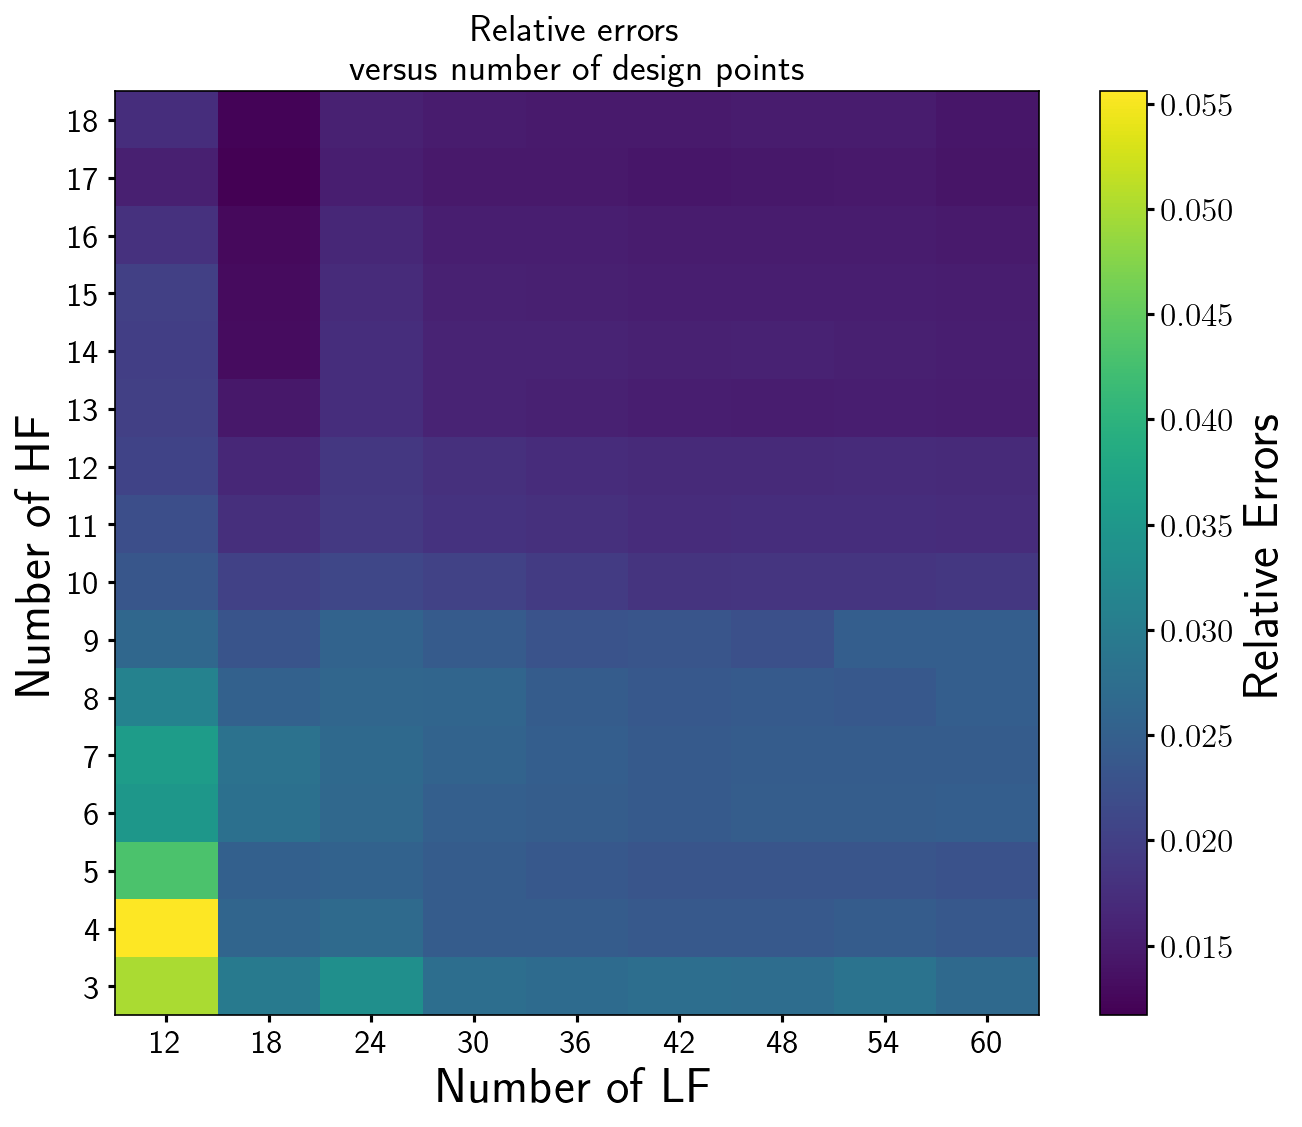

In [10]:
plot_grid_errors(all_ar1_errors, all_lfs, all_hfs)

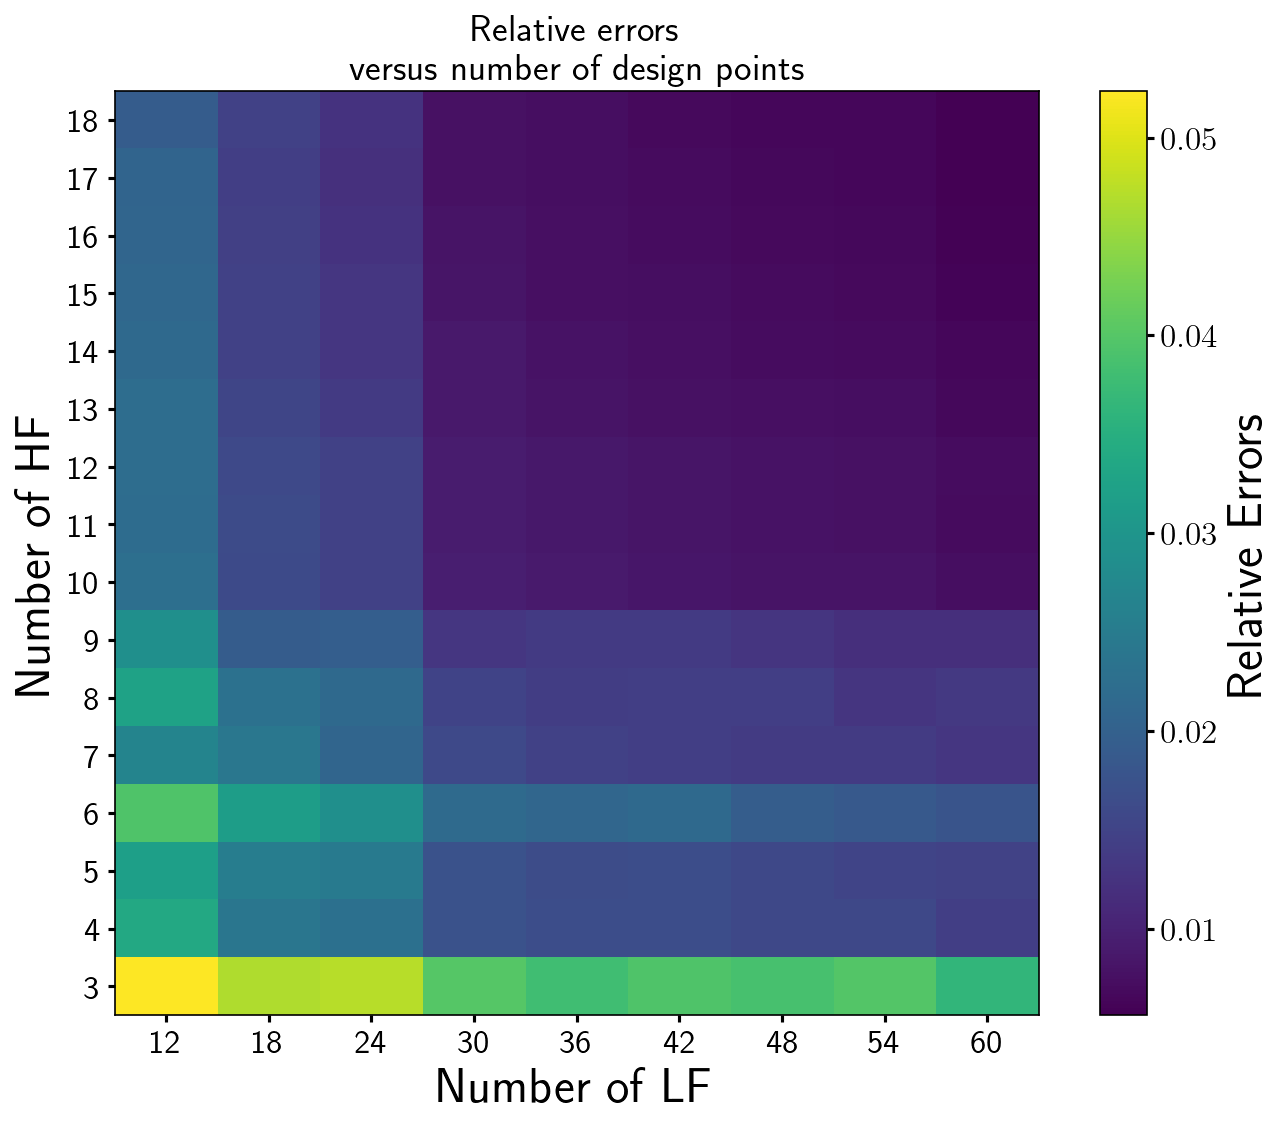

In [11]:
plot_grid_errors(all_nargp_errors, all_lfs, all_hfs)

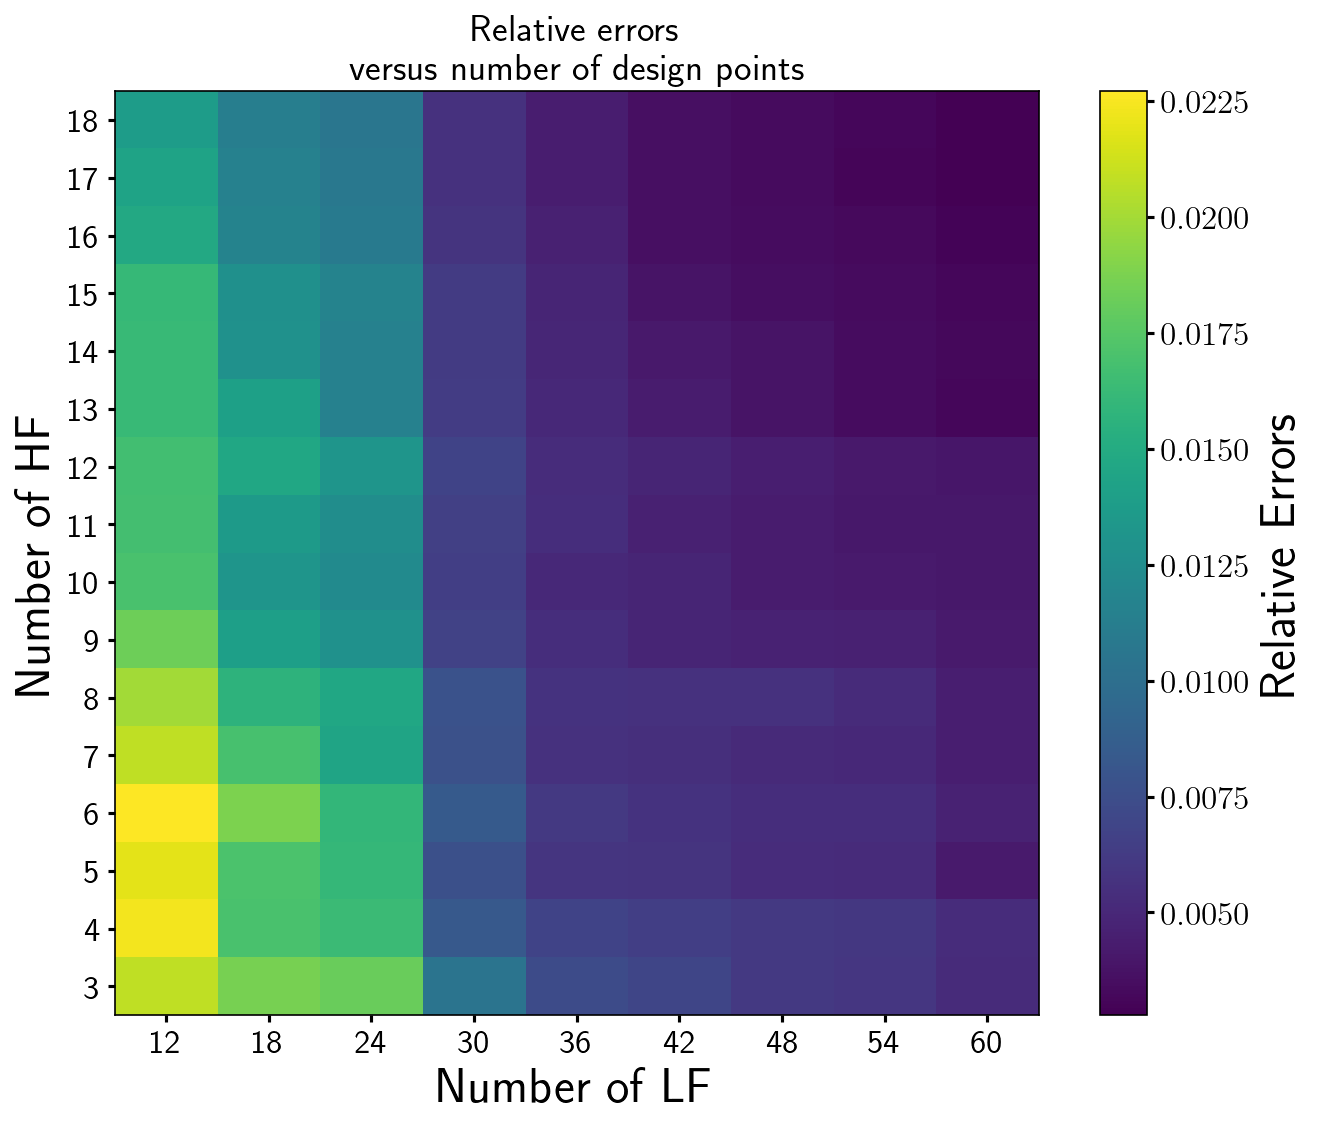

In [12]:
plot_grid_errors(all_dgmgp_errors, all_lfs, all_hfs)

## Test on the accuracy limit of LF-only emulator

In [12]:
vloaders.ar1_H3_slice19_added_360.num_lf

[12, 18, 24, 30, 36, 42, 48, 54, 60, 70, 80, 90, 100, 150, 200, 250, 300, 360]

In [11]:
vloaders.ar1_H3_slice19_added_360._pred_exacts_lf.shape

(18, 10, 96)

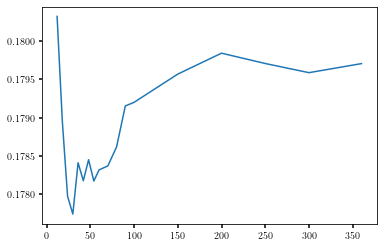

In [20]:
plt.plot(
    vloaders.ar1_H3_slice19_added_360.num_lf,
    np.abs(vloaders.ar1_H3_slice19_added_360._pred_exacts_lf - 1).mean(axis=(1, 2))
)

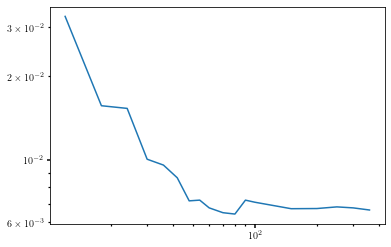

In [22]:
plt.loglog(
    vloaders.ar1_H3_slice19_added_360.num_lf,
    np.abs(vloaders.ar1_H3_slice19_added_360._pred_exacts - 1).mean(axis=(1, 2))
)

Train on 0 ~ 300, test on 60

In [23]:
from matter_multi_fidelity_emu.data_loader import PowerSpecs

In [30]:
import GPy

In [26]:
data = PowerSpecs()
data.read_from_txt("data/processed/Matterpower_360_res128box256_3_res512box256_z0_ind-57-58-59/")

In [37]:
x_test = data.X_train[0][:60]
x_train = data.X_train[0][60:]

y_test = data.Y_train[0][:60]
y_train = data.Y_train[0][60:]

In [47]:
# A loop to train and test
test_points = [6 * i for i in range(2, 51)]

errors = []

for n_lf in test_points:
    x = x_train[:n_lf]
    y = y_train[:n_lf]
    
    # Build your GP here
    nparams = np.shape(x)[1]

    kernel = GPy.kern.RBF(nparams, ARD=True)            

    gp = GPy.models.GPRegression(x, y, kernel)
    
    gp.optimize_restarts(10)
    
    # pred test set
    mean, variance = gp.predict(x_test)
    error = mean / y_test

    errors.append(error)
    
errors = np.array(errors)
errors.shape

Optimization restart 1/10, f = -453.4487985869986
Optimization restart 2/10, f = -453.4487985872622
Optimization restart 3/10, f = -453.4487985872985
Optimization restart 4/10, f = -453.4487985871833
Optimization restart 5/10, f = -453.44879853991733
Optimization restart 6/10, f = -453.44879858222976
Optimization restart 7/10, f = -453.4487985861873
Optimization restart 8/10, f = -453.4487976636251
Optimization restart 9/10, f = -453.4487985650177
Optimization restart 10/10, f = -453.4487985837495
Optimization restart 1/10, f = -1036.2039673925365
Optimization restart 2/10, f = -1036.2039673245447
Optimization restart 3/10, f = -1036.2039673950944
Optimization restart 4/10, f = -1036.2039673945465
Optimization restart 5/10, f = -1037.5436684011793
Optimization restart 6/10, f = -1036.2039672438937
Optimization restart 7/10, f = -1036.2039673800728
Optimization restart 8/10, f = -1036.203967395997
Optimization restart 9/10, f = -1036.203967377713
Optimization restart 10/10, f = -1036.20

Optimization restart 5/10, f = -12640.527180468955
Optimization restart 6/10, f = -12640.527182900667
Optimization restart 7/10, f = -12640.5271605711
Optimization restart 8/10, f = -12640.527182976957
Optimization restart 9/10, f = -12640.527179998866
Optimization restart 10/10, f = -12640.527165190555
Optimization restart 1/10, f = -13402.684008842803
Optimization restart 2/10, f = -13402.68401027232
Optimization restart 3/10, f = -13402.68400784503
Optimization restart 4/10, f = -13402.684011036961
Optimization restart 5/10, f = -13402.68401091381
Optimization restart 6/10, f = -13402.68400366453
Optimization restart 7/10, f = -13402.683980589376
Optimization restart 8/10, f = -13402.684011355484
Optimization restart 9/10, f = -13402.684011411184
Optimization restart 10/10, f = -13402.684011743253
Optimization restart 1/10, f = -14197.707636354799
Optimization restart 2/10, f = -14197.70760155196
Optimization restart 3/10, f = -14197.707636367053
Optimization restart 4/10, f = -1419

Optimization restart 8/10, f = -24810.894350587245
Optimization restart 9/10, f = -24810.89432413805
Optimization restart 10/10, f = -24810.89433126917
Optimization restart 1/10, f = -25696.804009242936
Optimization restart 2/10, f = -25696.80379680286
Optimization restart 3/10, f = -25696.804010663593
Optimization restart 4/10, f = -25696.803990695167
Optimization restart 5/10, f = -25696.804000024706
Optimization restart 6/10, f = -25696.80400600749
Optimization restart 7/10, f = -25696.80400835369
Optimization restart 8/10, f = -25696.804010459797
Optimization restart 9/10, f = -25696.80396565972
Optimization restart 10/10, f = -25696.804004486345
Optimization restart 1/10, f = -26498.118963607154
Optimization restart 2/10, f = -26498.118990099065
Optimization restart 3/10, f = -26498.11898929582
Optimization restart 4/10, f = -26498.118990595736
Optimization restart 5/10, f = -26498.118978970833
Optimization restart 6/10, f = -26498.118988170325
Optimization restart 7/10, f = -2649

(49, 60, 96)

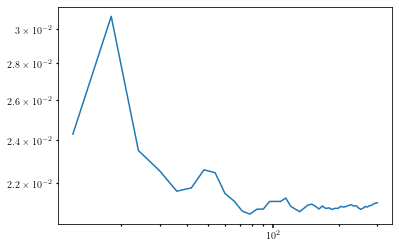

In [58]:
mean = np.abs(errors - 1).mean(axis=(1, 2))
std  = np.abs(errors - 1).std(axis=(1, 2))

plt.loglog(test_points, mean)
# plt.fill_between(test_points, y1=mean - std, y2=mean + std, alpha=0.2)

# plt.fill_between(test_points, y1=mean - std, y2=mean + std, alpha=0.2)